### Centroid_test_profile

This script reads a profile exported by Global Mapper, running from land -> ocean. Volumes and volume centroids are calculated two ways:

* Profiles are clipped to seaward extent of shorted profiles, then missing data is replaced with the September fill surface intepolated by Andy.

* Profiles are extended downward using the last two points after missing data is replaced with the September fill surface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from scipy import interpolate, signal, stats

%matplotlib inline

In [2]:
profname = 'profile_a'
pathname = "D:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\{}.csv".format(profname)
df=pd.read_csv(pathname,header = 0)
#print(df)
print("Read: ",len(df.index),' lines.')
df

Read:  1024  lines.


,ID,X,Y,Elevation,Elevation (EBK_201909_NoLidar_Comb_Extent_clipped_to_Nov.tif),Elevation (2019-08-30_1m_DEM_4D_crop2.tif),Elevation (2019-09-12-13_1mDEM_4D_v3.tif),Elevation (2019-10-11_1m_DEM_4D_crop.tif),Elevation (2019-11-26_1m_DEM_4D_crop.tif),Distance (Segment),Distance (Total),Distance 3D (Segment),Distance 3D (Total),Slope (Degrees),Slope (Percent),Segment Index
0,1,386574.285,3863982.707,0.847,1.002,0.864,0.960,0.902,0.847,0.0000,0.0000,0.0000,0.0000,-,-,1
1,2,386574.491,3863982.476,0.849,0.997,0.863,0.967,0.905,0.849,0.3091,0.3091,0.3091,0.3091,0.5,0.8%,1
2,3,386574.696,3863982.246,0.853,0.988,0.865,0.976,0.910,0.853,0.3091,0.6180,0.3091,0.6180,0.6,1.0%,1
3,4,386574.902,3863982.015,0.850,0.992,0.867,0.983,0.913,0.850,0.3091,0.9270,0.3091,0.9270,0.5,0.8%,1
4,5,386575.107,3863981.784,0.843,1.008,0.869,0.988,0.913,0.843,0.3091,1.2360,0.3092,1.2360,1.4,2.4%,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1020,386783.656,3863747.519,-0.071,NaN,NaN,NaN,NaN,NaN,0.3091,314.9600,0.3091,315.2000,0.0,0.0%,1
1020,1021,386783.862,3863747.288,-0.071,NaN,NaN,NaN,NaN,NaN,0.3091,315.2700,0.3091,315.5100,0.0,0.0%,1
1021,1022,386784.067,3863747.057,-0.071,NaN,NaN,NaN,NaN,NaN,0.3091,315.5700,0.3091,315.8200,0.0,0.0%,1
1022,1023,386784.273,3863746.826,-0.071,NaN,NaN,NaN,NaN,NaN,0.3091,315.8800,0.3091,316.1300,0.0,0.0%,1


In [3]:
nmaps = 4
dist = np.array(df['Distance (Total)'])
Aug = np.array(df['Elevation (2019-08-30_1m_DEM_4D_crop2.tif)'])
Sep = np.array(df['Elevation (2019-09-12-13_1mDEM_4D_v3.tif)'])
Oct = np.array(df['Elevation (2019-10-11_1m_DEM_4D_crop.tif)'])
Nov = np.array(df['Elevation (2019-11-26_1m_DEM_4D_crop.tif)'])
Sep_fill = np.array(df['Elevation (EBK_201909_NoLidar_Comb_Extent_clipped_to_Nov.tif)'])
dx = np.array(df['Distance (Segment)'])[1]
print('dx: ',dx)
#cols=['#fef0d9','#fdcc8a','#fc8d59','#d7301f']
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

profs = np.array([Aug,Sep,Oct,Nov])
nmaps,lp = np.shape(profs)
print("nmaps, length profiles: ",nmaps,lp)
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']

print("Stack of profiles with shape: ",np.shape(profs))

dx:  0.3091
nmaps, length profiles:  4 1024
Stack of profiles with shape:  (4, 1024)


In [4]:
def centroid(x,z):
    cz = np.nanmean(z)
    cx = np.nansum(z*x)/np.nansum(z)
    return(cx,cz)

1024 744
Short arrays have shape:  (4, 744)
28-Aug
  Nans: 0 0
13-Sep
  Nans: 0 0
11-Oct
  Nans: 134 0
26-Nov
  Nans: 0 0


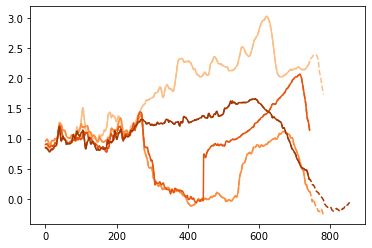

In [5]:
### Method 0 - Trim profiles to match shortest one
# this convoluted proceedure looks from the ocean side and finds the first good value in each profile
# the largest of these is associated with the shortest profile
#array of last good values
ii = np.ones((nmaps),dtype=np.int32)
iend = np.ones((nmaps),dtype=np.int32)
iend2 = np.ones((nmaps),dtype=np.int32)

for i in range(0,nmaps):
    ix=np.argwhere(np.isfinite(np.flip(profs[i,:])))
    ii[i]=int(ix[0]-1)
    iend[i]=int(lp-ix[0])

#     iend2[i]=int(lp-ii[i]+1)
#     print(iend[i],iend2[i])
    
# index to end of shortest array
# imx = np.max(ii)
# ishort = lp-(imx+1)
ishort = np.min(iend)
print(lp,ishort)

# make clipped arrays
pshort = np.zeros((nmaps,ishort))
print("Short arrays have shape: ",np.shape(pshort))
dists = dist[0:ishort].copy()
Sep_fill_short = Sep_fill[0:ishort].copy()
for i in range(0,nmaps):
    pshort[i,:] = profs[i,0:ishort]

for i in range(0,nmaps):
    print(pnames[i])
    idx = np.argwhere(np.isnan(pshort[i,:]))
    pshort[i,idx]=Sep_fill_short[idx].copy()
    print('  Nans:', len(idx), np.sum(np.isnan(pshort[i,:])))

for i in range(0,nmaps):
    plt.plot(profs[i,:],'--',c=cols[i+1])
for i in range(0,nmaps):
    plt.plot(pshort[i,:],'-',c=cols[i+1])


28-Aug
  Nans: 241 241
13-Sep
  Nans: 241 241
11-Oct
  Nans: 414 277
26-Nov
  Nans: 167 167


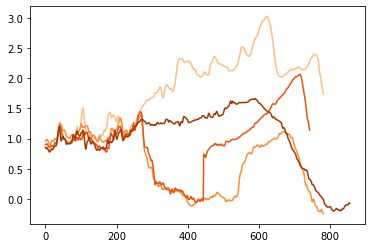

In [6]:
### Method 1 - Replace any missing data with available Sep_fill and extend profiles
# replace missing data in Oct and Nov with Sep_fill
proff = profs.copy()
for i in range(0,nmaps):
    print(pnames[i])
    idx = np.argwhere(np.isnan(profs[i,:]))
    proff[i,idx]=Sep_fill[idx].copy()
    print('  Nans:', len(idx), np.sum(np.isnan(proff[i,:])))

# but then remove data added at seaward end
for i in range(0,nmaps):
    proff[i,iend[i]:]=np.nan
    
for i in range(0,nmaps):
    plt.plot(proff[i,:],'-',c=cols[i+1])

In [7]:
# extend profile using last two points
# (ilast is actually first nan)
profx = proff.copy()
for i in range(0,4):
    ilast = np.argwhere(np.isnan(proff[i,:]))[0]
    slp = (proff[i,ilast-1]-proff[i,ilast-2])/dx
    print(ilast,proff[i,ilast-1],proff[i,ilast-2],slp)
    if(slp<0):
        # extend profile
        profx[i,int(ilast):]=proff[i,int(ilast)-1]+slp*(dist[int(ilast):]-dist[int(ilast)-1])
    else:
        # fill end of profile with zeros
        profx[i,int(ilast):]=0.
        
# Or...fit to last 5 meters
profx2=proff.copy()
npts = int(5/dx)
for i in range(0,4):
    ilast = int(np.argwhere(np.isnan(proff[i,:]))[0])
    p = np.polyfit( dist[(ilast-npts-1):(ilast-1)], proff[i,(ilast-npts-1):(ilast-1)], 1)
    print(p)
    if(p[0]<0.):
        profx2[i,ilast:]=np.polyval(p,dist[ilast:])
    else:
        profx2[i,ilast:]=0.

[783] [1.735] [1.754] [-0.06146878]
[783] [-0.246] [-0.245] [-0.0032352]
[744] [1.139] [1.175] [-0.11646716]
[857] [-0.071] [-0.065] [-0.01941119]
[-0.12260297 31.34434661]
[-0.00477222  0.93917657]
[-0.13032789 31.04776221]
[ 0.0148183  -3.98051026]


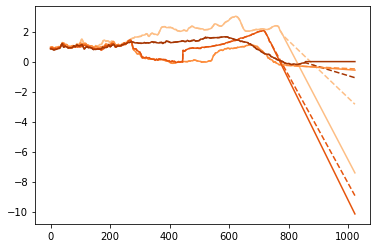

In [8]:
for i in range(0,nmaps):
    plt.plot(profx[i,:],'--',c=cols[i+1])
for i in range(0,nmaps):
    plt.plot(profx2[i,:],'-',c=cols[i+1])

In [9]:
# volumes for extended profiles
datum=0.4
profd = profx2.copy()-datum
profd[np.where(profd<=0.)]=0.
vd=np.sum(profd,1)*dx
print("Profile volumes: ", vd)

# volumes for clipped (short) profiles
profds = pshort.copy()-datum
profds[np.where(profds<=0.)]=0.
vds=np.sum(profds,1)*dx
print("Short profile volumes: ",vds)

Profile volumes:  [350.46622067  87.543302   142.90387538 179.4891153 ]
Short profile volumes:  [321.8247197  87.543302  141.0358389 179.4891153]


In [10]:
# centroids for extended profiles
cxcy = np.zeros((4,2))
for i in range(0,4):
    cxcy[i,0],cxcy[i,1] = centroid(dist,profx2[i,:])
print("Centroids: \n",cxcy)

# centroids for short profiles
cxcys = np.zeros((4,2))
for i in range(0,4):
    cxcy[i,0],cxcy[i,1] = centroid(dists,pshort[i,:])
print("Centroids: \n",cxcy)

Centroids: 
 [[-1.01352640e+01  7.15106494e-01]
 [ 5.09789556e+01  3.88129823e-01]
 [ 4.99615998e+02 -5.44754534e-01]
 [ 1.19015780e+02  8.52755094e-01]]
Centroids: 
 [[133.90750911   1.79941801]
 [ 97.17678172   0.66720194]
 [127.94533795   0.95942056]
 [119.87643235   1.18014651]]


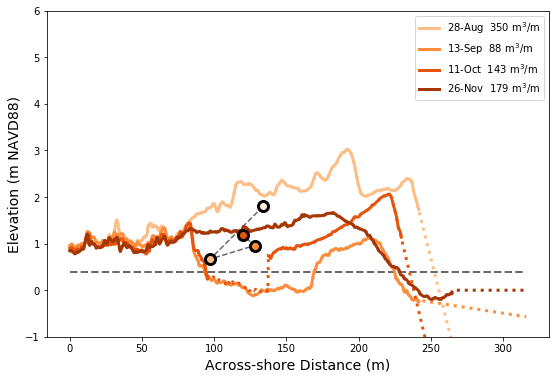

In [11]:
#fig = plt.figure(figsize=(9,6))
fig, ax = plt.subplots(1,1,figsize=(9,6))

plt.plot(dist,np.ones_like(dist)*datum,'--',c='dimgray',linewidth=2)
plt.plot(cxcy[0:4,0],cxcy[0:4,1],'--',c='dimgray')
for i in range(0,4):
    lab = '{0} {1: .0f} m$^3$/m'.format(pnames[i],vd[i])
    plt.plot(dist,profs[i,:],'-',linewidth=3,c=cols[i+1],label=lab)
    plt.plot(dist,profx2[i,:],':',linewidth=3,c=cols[i+1])
for i in range(0,4):
    plt.plot(cxcy[i,0],cxcy[i,1],'ok',ms=12)
    plt.plot(cxcy[i,0],cxcy[i,1],'o',c=cols[i])

plt.legend()
plt.ylim((-1., 6.))
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlabel('Across-shore Distance (m)',fontsize=14)
pname = '{}.svg'.format(profname)
plt.savefig(pname)

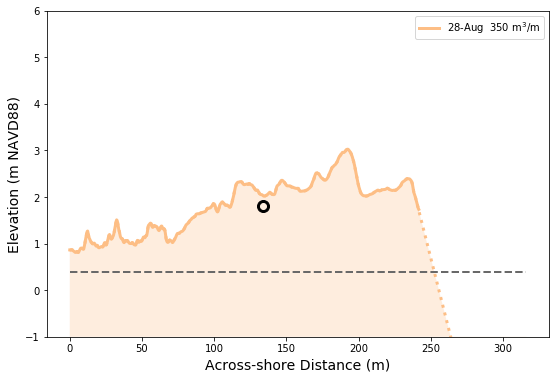

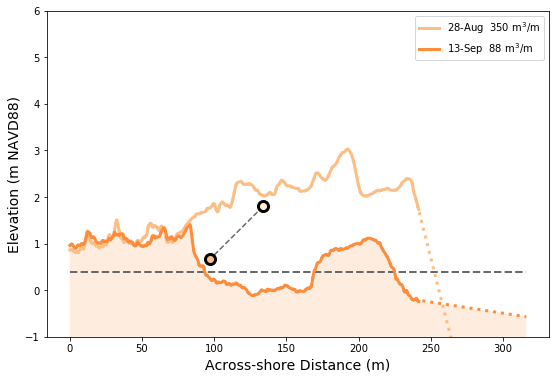

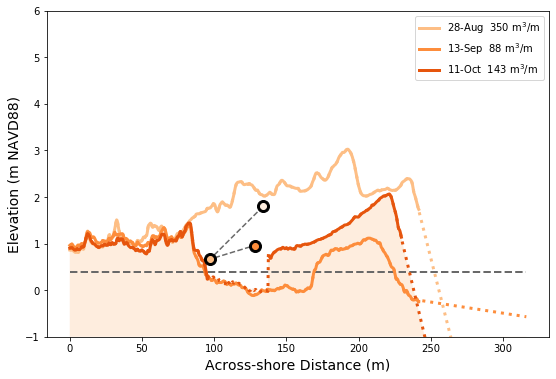

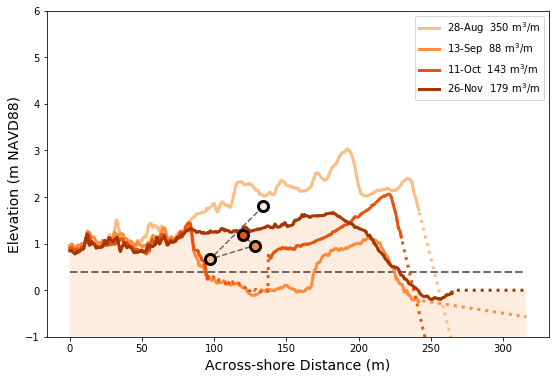

In [12]:
i=0
fig, ax = plt.subplots(1,1,figsize=(9,6))
plt.plot(dist,np.ones_like(dist)*datum,'--',c='dimgray',linewidth=2)
lab = '{0} {1: .0f} m$^3$/m'.format(pnames[i],vd[i])
plt.plot(dist,profs[i,:],'-',linewidth=3,c=cols[i+1],label=lab)
plt.plot(dist,profx2[i,:],':',linewidth=3,c=cols[i+1])
plt.plot(cxcy[i,0],cxcy[i,1],'ok',ms=12)
plt.plot(cxcy[i,0],cxcy[i,1],'o',c=cols[i])
ax.fill_between(dist,-1,profx2[i,:],facecolor=cols[0])
plt.legend()
plt.ylim((-1., 6.))
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlabel('Across-shore Distance (m)',fontsize=14)
pname = '{}_{}.svg'.format(profname,0)
plt.savefig(pname)

fig, ax = plt.subplots(1,1,figsize=(9,6))
plt.plot(dist,np.ones_like(dist)*datum,'--',c='dimgray',linewidth=2)
for i in range(0,2):
    lab = '{0} {1: .0f} m$^3$/m'.format(pnames[i],vd[i])
    plt.plot(dist,profs[i,:],'-',linewidth=3,c=cols[i+1],label=lab)
    plt.plot(dist,profx2[i,:],':',linewidth=3,c=cols[i+1])
plt.plot(cxcy[0:2,0],cxcy[0:2,1],'--',c='dimgray')
for i in range(0,2):
    plt.plot(cxcy[i,0],cxcy[i,1],'ok',ms=12)
    plt.plot(cxcy[i,0],cxcy[i,1],'o',c=cols[i])
ax.fill_between(dist,-1,profx2[1,:],facecolor=cols[0])
plt.legend()
plt.ylim((-1., 6.))
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlabel('Across-shore Distance (m)',fontsize=14)
pname = '{}_{}.svg'.format(profname,1)
plt.savefig(pname)

fig, ax = plt.subplots(1,1,figsize=(9,6))
plt.plot(dist,np.ones_like(dist)*datum,'--',c='dimgray',linewidth=2)
for i in range(0,3):
    lab = '{0} {1: .0f} m$^3$/m'.format(pnames[i],vd[i])
    plt.plot(dist,profs[i,:],'-',linewidth=3,c=cols[i+1],label=lab)
    plt.plot(dist,profx2[i,:],':',linewidth=3,c=cols[i+1])
plt.plot(cxcy[0:3,0],cxcy[0:3,1],'--',c='dimgray')
for i in range(0,3):
    plt.plot(cxcy[i,0],cxcy[i,1],'ok',ms=12)
    plt.plot(cxcy[i,0],cxcy[i,1],'o',c=cols[i])
ax.fill_between(dist,-1,profx2[2,:],facecolor=cols[0])
plt.legend()
plt.ylim((-1., 6.))
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlabel('Across-shore Distance (m)',fontsize=14)
pname = '{}_{}.svg'.format(profname,2)
plt.savefig(pname)

fig, ax = plt.subplots(1,1,figsize=(9,6))
plt.plot(dist,np.ones_like(dist)*datum,'--',c='dimgray',linewidth=2)
for i in range(0,4):
    lab = '{0} {1: .0f} m$^3$/m'.format(pnames[i],vd[i])
    plt.plot(dist,profs[i,:],'-',linewidth=3,c=cols[i+1],label=lab)
    plt.plot(dist,profx2[i,:],':',linewidth=3,c=cols[i+1])
plt.plot(cxcy[0:4,0],cxcy[0:4,1],'--',c='dimgray')
for i in range(0,4):
    plt.plot(cxcy[i,0],cxcy[i,1],'ok',ms=12)
    plt.plot(cxcy[i,0],cxcy[i,1],'o',c=cols[i])
ax.fill_between(dist,-1,profx2[3,:],facecolor=cols[0])
plt.legend()
plt.ylim((-1., 6.))
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlabel('Across-shore Distance (m)',fontsize=14)
pname = '{}_{}.svg'.format(profname,3)
plt.savefig(pname)